In [ ]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for _ in range(self.n_views)]

In [ ]:
import torchvision.transforms as transforms

contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=28, scale=(0.7, 1), ratio=(1, 1)),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1
                )
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [48]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import Subset
import torch

train_dataset = FashionMNIST(
    "./data",
    train=True,
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
# train_dataset = Subset(train_dataset, indices=torch.randperm(len(train_dataset))[:1000])

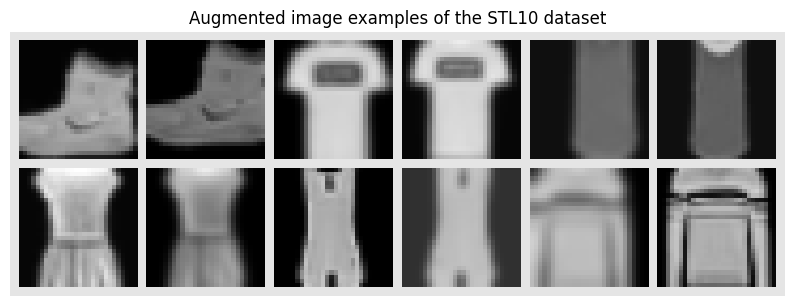

In [56]:
import matplotlib.pyplot as plt
import torch
import torchvision

NUM_IMAGES = 6
imgs = torch.stack(
    [img for idx in range(NUM_IMAGES) for img in train_dataset[idx][0]], dim=0
)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [57]:
import torch.nn.functional as F


def info_nce_loss(
    batch,
    encoder,
    temp=0.1,
    mode="train",
    device: torch.types.Device = torch.device("cuda"),
):
    imgs, _ = batch
    imgs = torch.cat(imgs, dim=0)
    imgs = imgs.to(device)

    # Encode all images
    feats = encoder(imgs)
    # Calculate cosine similarity
    cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    # InfoNCE loss
    cos_sim = cos_sim / temp
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    # Logging loss
    # print(mode + "_loss", nll)
    # Get ranking position of positive example
    comb_sim = torch.cat(
        [
            cos_sim[pos_mask][:, None],  # First position positive example
            cos_sim.masked_fill(pos_mask, -9e15),
        ],
        dim=-1,
    )
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    # Logging ranking metrics
    # print(mode + "_acc_top1", (sim_argsort == 0).float().mean())
    # print(mode + "_acc_top5", (sim_argsort < 5).float().mean())
    # print(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

    return nll

In [58]:
from timm.models.vision_transformer import VisionTransformer
import torch.nn as nn


class SimCLRViT(VisionTransformer):
    def __init__(self, device="cuda"):
        super().__init__(
            img_size=28,
            patch_size=4,
            in_chans=1,
            num_classes=10,
            embed_dim=64,
            depth=4,
            num_heads=4,
            mlp_ratio=4,
            norm_layer=nn.LayerNorm,
            device=device,
        )

In [59]:
# Setup SSL training
import timm
from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=16)

epochs = 100
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = timm.create_model("vit_base_patch16_224", pretrained=False).to(device)
model = SimCLRViT(device)
# model = torch.load("ViT-custom.pth", weights_only=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs * len(train_loader))

In [ ]:
from tqdm import tqdm

for i in range(epochs):
    running_loss = 0.0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        loss = info_nce_loss(batch, encoder=model)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item()

    avg = running_loss / len(train_loader)
    print(f"Epoch {i+1}/{epochs} - Loss: {avg:.4f} Lr: {lr_scheduler.get_last_lr()[0]}")


torch.save(model.state_dict(), "ViT-simCLR.pth")

# Validation

In [62]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset
import torch

val_dataset = FashionMNIST(
    "./data",
    train=False,
    transform=transforms.Compose(
        [
            # transforms.Grayscale(3),
            # transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    download=True,
)

head_val, head_train = torch.utils.data.random_split(val_dataset, (0.4, 0.6))
# head_train = Subset(head_train, indices=torch.randperm(len(head_train))[:1000])

In [66]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

head_train_loader = DataLoader(head_train, batch_size=256, num_workers=16)

custom_vit = SimCLRViT(device).to(device)
custom_vit.load_state_dict(torch.load("ViT-simCLR.pth"))
custom_vit.head = nn.Identity()
# custom_vit = timm.create_model("vit_base_patch16_224", pretrained=True).to(device)
custom_vit.eval()
linear_head = nn.Linear(64, 10).to(device)
CE_loss = nn.CrossEntropyLoss()
head_optimizer = torch.optim.Adam(linear_head.parameters(), lr=1e-3)
epochs = 10


for epoch in range(epochs):
    linear_head.train()
    total_loss = 0
    for imgs, labels in tqdm(head_train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        head_optimizer.zero_grad()
        with torch.no_grad():
            feats = custom_vit(imgs)
        logits = linear_head(feats)
        loss = CE_loss(logits, labels)
        prediction = torch.argmax(logits)
        loss.backward()
        head_optimizer.step()
        total_loss += loss.item()

    avg = total_loss / len(head_train_loader)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg:4f}")

torch.save(linear_head, "linear_head.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'ViT-simCLR.pth'

In [65]:
head_val_loader = DataLoader(head_val, batch_size=256, num_workers=16)

linear_head = torch.load('linear_head.pth', weights_only=False)

linear_head.eval()
custom_vit.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in tqdm(head_val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        feats = custom_vit(imgs)
        logits = linear_head(feats)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

100%|██████████| 16/16 [00:00<00:00, 21.93it/s]

Test Accuracy: 75.33%
